In [2]:
!pip install opencv-python

                                              0.0/38.1 MB ? eta -:--:--
                                              0.0/38.1 MB ? eta -:--:--
                                              0.0/38.1 MB ? eta -:--:--
                                             0.1/38.1 MB 880.9 kB/s eta 0:00:44
                                             0.1/38.1 MB 880.9 kB/s eta 0:00:44
                                              0.3/38.1 MB 1.1 MB/s eta 0:00:34
                                              0.6/38.1 MB 2.3 MB/s eta 0:00:17
     -                                        1.6/38.1 MB 5.2 MB/s eta 0:00:07
     --                                       2.7/38.1 MB 7.6 MB/s eta 0:00:05
     --                                       2.8/38.1 MB 6.8 MB/s eta 0:00:06
     -----                                    5.0/38.1 MB 11.0 MB/s eta 0:00:04
     ------                                   6.5/38.1 MB 13.0 MB/s eta 0:00:03
     --------                                 8.2/38.1 MB 15.0 MB/s e

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go
import glob
import cv2

In [30]:
mask_files = glob.glob('data/archive/lgg-mri-segmentation/kaggle_3m/*/*_mask.tif')

train_files = []
for i in mask_files:
    train_files.append(i.replace('_mask', ''))
    

In [36]:
print(len(mask_files))
len(train_files)

3929
True


10

In [38]:
mask = mask_files[10]
train = train_files[10]
train, mask

('data/archive/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_1.tif',
 'data/archive/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_1_mask.tif')

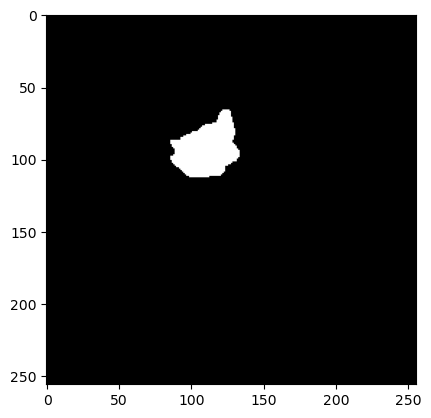

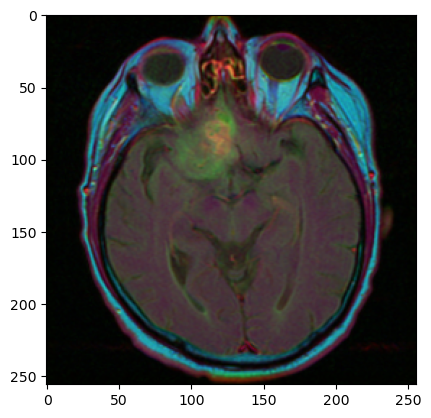

In [25]:
img = cv2.imread(mask)
plt.imshow(img)
plt.show()

img2 = cv2.imread(train)
plt.imshow(img2)
plt.show()